# Supervised Learning of Drug Response using CORES from Copy Number Log Ratio

### Import Python source code

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 26 12:21:38 2018

@author: bbece
"""

from __future__ import division, print_function, unicode_literals
import numpy as np
import os

from pprint import pprint
np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
            
import pandas as pd
import scipy

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math



### Define method to split training and testing set

In [2]:
# TODO: Manipulate test_ratio
def split_train_test(training_set, test_ratio = 0.33):
    row_count = training_set.shape[0]
    shuffled_indices = np.random.permutation(row_count)
    test_set_size = int(test_ratio * row_count)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return training_set.iloc[train_indices], training_set.iloc[test_indices]
    
    


### Load training set matrix

In [4]:
labeled_matrix_training_set = pd.read_csv("../mlOutput/coreTrainingSet_7_31_2018_1.csv")
labeled_matrix_training_set.columns.values[0] = "sampleId"
labels = list(range(1,6))


### Visualize ML results using Linear Regression

0.1002328062
Pearson: (0.16606840422977201, 0.6059758732133147)
Spearman: SpearmanrResult(correlation=0.027972027972027972, pvalue=0.93123435120188069)


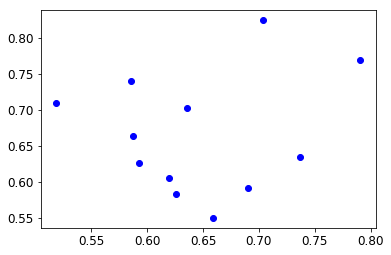

1.02290757929
Pearson: (0.02430633138676953, 0.9402307317185451)
Spearman: SpearmanrResult(correlation=0.034965034965034975, pvalue=0.91409334241075979)


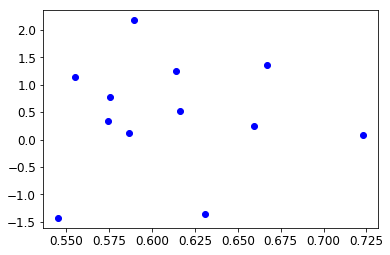

0.331531345726
Pearson: (-0.020515024163474345, 0.94954212757077572)
Spearman: SpearmanrResult(correlation=0.048951048951048952, pvalue=0.87991857887867486)


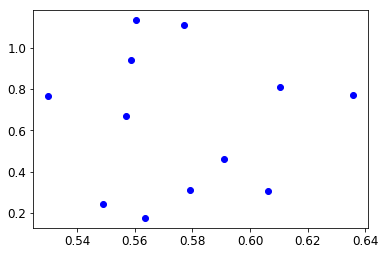

1.31272966288
Pearson: (0.18718821178951298, 0.58154004305654805)
Spearman: SpearmanrResult(correlation=-0.0090909090909090922, pvalue=0.97883650014419354)


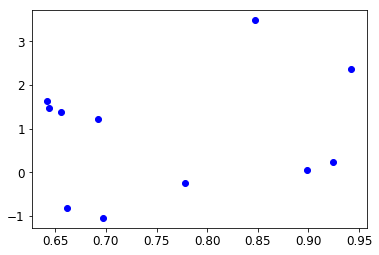

0.21532573865
Pearson: (0.063578433545672483, 0.85267204567135546)
Spearman: SpearmanrResult(correlation=0.15454545454545454, pvalue=0.65003396549757997)


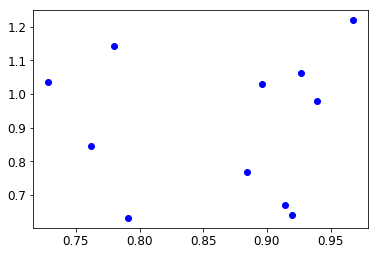

In [5]:
for label in labels:
    # Remove uneeded labels
    selected_training_set = labeled_matrix_training_set.iloc[:, list([0]) + list([label]) + list(range(6,labeled_matrix_training_set.shape[1]))].copy()
    selected_training_set = selected_training_set[np.isfinite(selected_training_set.iloc[:,1])]
    training_set, testing_set = split_train_test(selected_training_set)
    model_data = training_set.copy().drop([training_set.columns[0], training_set.columns[1]], axis = 1)
    model_labels = training_set.iloc[:,1]
    lasso = LinearRegression()
    lasso.fit(model_data, model_labels)
    model_test_data = testing_set.copy().drop([training_set.columns[0], training_set.columns[1]], axis = 1)
    model_test_labels = testing_set.iloc[:,1]
    predictions = lasso.predict(model_test_data)
    mse = mean_squared_error(model_test_labels, predictions)
    rmse = np.sqrt(mse)
    print(rmse)
    r = scipy.stats.pearsonr(model_test_labels, predictions)
    t = scipy.stats.spearmanr(model_test_labels, predictions)
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))
    plt.plot(model_test_labels, predictions, 'bo')
    plt.show()

### Visualize ML results using Random Forest Regressor

0.0644747843007
Pearson: (0.46969209889598179, 0.12339790944116805)
Spearman: SpearmanrResult(correlation=0.45454545454545459, pvalue=0.13765791634772945)


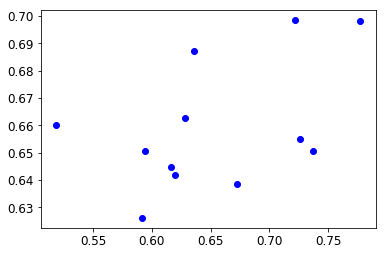

0.0730038729482
Pearson: (0.092860248138121285, 0.77408384203719249)
Spearman: SpearmanrResult(correlation=0.090909090909090925, pvalue=0.7787253962454419)


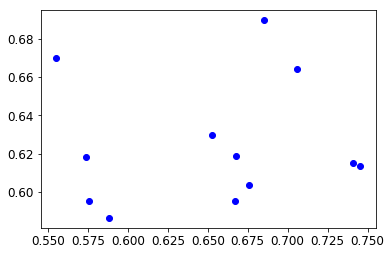

0.0626455365993
Pearson: (0.065164393712107541, 0.8405390045234844)
Spearman: SpearmanrResult(correlation=-0.013986013986013986, pvalue=0.96559026891877953)


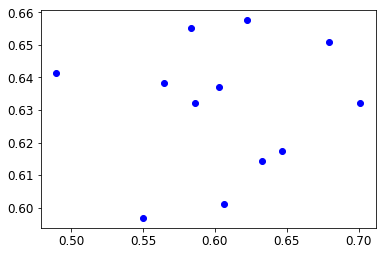

0.0992438848368
Pearson: (0.11090646841079428, 0.74545791574998255)
Spearman: SpearmanrResult(correlation=0.27272727272727276, pvalue=0.41714143714253127)


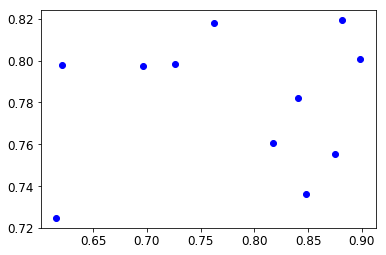

0.0879547762465
Pearson: (0.038759380961688523, 0.90991802571187186)
Spearman: SpearmanrResult(correlation=0.018181818181818184, pvalue=0.95768524102161867)


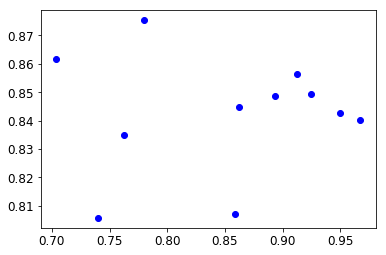

In [6]:
for label in labels:
    # Remove uneeded labels
    selected_training_set = labeled_matrix_training_set.iloc[:, list([0]) + list([label]) + list(range(6,labeled_matrix_training_set.shape[1]))].copy()
    selected_training_set = selected_training_set[np.isfinite(selected_training_set.iloc[:,1])]
    training_set, testing_set = split_train_test(selected_training_set)
    model_data = training_set.copy().drop([training_set.columns[0], training_set.columns[1]], axis = 1)
    model_labels = training_set.iloc[:,1]
    lasso = RandomForestRegressor(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
    lasso.fit(model_data, model_labels)
    model_test_data = testing_set.copy().drop([training_set.columns[0], training_set.columns[1]], axis = 1)
    model_test_labels = testing_set.iloc[:,1]
    predictions = lasso.predict(model_test_data)
    mse = mean_squared_error(model_test_labels, predictions)
    rmse = np.sqrt(mse)
    print(rmse)
    r = scipy.stats.pearsonr(model_test_labels, predictions)
    t = scipy.stats.spearmanr(model_test_labels, predictions)
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))
    plt.plot(model_test_labels, predictions, 'bo')
    plt.show()
